## Initial Data Ingestion

In [300]:
import pandas as pd
import seaborn as sns
from datetime import date
import time

In [301]:
df = pd.read_csv("data/Visadataset.csv")
df.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


### Creating the date object of today's date

In [302]:
todays_date = date.today()
current_year= todays_date.year

df['company_age'] = current_year-df['yr_of_estab']
df.drop('yr_of_estab', inplace=True, axis=1)

In [303]:
features = df.drop(["case_status","case_id"],axis=1)
target = df[["case_status"]]
case_id = df["case_id"]

In [304]:
features.head()

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,company_age
0,Asia,High School,N,N,14513,West,592.2029,Hour,Y,15
1,Asia,Master's,Y,N,2412,Northeast,83425.6500,Year,Y,20
2,Asia,Bachelor's,N,Y,44444,West,122996.8600,Year,Y,14
3,Asia,Bachelor's,N,N,98,West,83434.0300,Year,Y,125
4,Africa,Master's,Y,N,1082,South,149907.3900,Year,Y,17


In [305]:
target.head()

,case_status
0,Denied
1,Certified
2,Denied
3,Denied
4,Certified


In [306]:
case_id.head()

0    EZYV01
1    EZYV02
2    EZYV03
3    EZYV04
4    EZYV05
Name: case_id, dtype: object

### Feature Engineering 

In [307]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline


ordinal_columns = ['has_job_experience','requires_job_training','full_time_position','education_of_employee']

onehot_columns = ['continent','unit_of_wage','region_of_employment']

transform_columns= ['no_of_employees','company_age']

num_features = ['prevailing_wage']


numeric_transformer = StandardScaler()
onehot_transformer = OneHotEncoder()
ordinal_encoder = OrdinalEncoder()

transform_pipe = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson', standardize=True))
])

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", onehot_transformer, onehot_columns),
        ("Ordinal_Encoder", ordinal_encoder, ordinal_columns),
        ("Transformer", transform_pipe, transform_columns),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [308]:
preprocessed_features = preprocessor.fit_transform(features)

In [309]:
len(preprocessed_features[0])

22

In [310]:
columns = preprocessor.get_feature_names_out()


In [311]:
preprocessed_columns = []
for column in columns:
    preprocessed_columns.append(column.split("__")[1])
    
features = pd.DataFrame(preprocessed_features,columns=preprocessed_columns)

In [312]:
features.head()

,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,unit_of_wage_Hour,unit_of_wage_Month,unit_of_wage_Week,unit_of_wage_Year,...,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,has_job_experience,requires_job_training,full_time_position,education_of_employee,no_of_employees,company_age,prevailing_wage
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.517300,-0.943712,-1.398537
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,3.0,0.030912,-0.454005,0.169835
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.885076,-1.069026,0.919079
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.343550,1.625983,0.169994
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,3.0,-0.432287,-0.724210,1.428604


### Timestamp & Unique id is Required

In [271]:
timestamps = pd.date_range(end = pd.Timestamp.now(),
                           periods = len(df),freq = 'D').to_frame(name = 'event_timestamp', index = False)


timestamps.head()

,event_timestamp
0,1953-02-19 15:46:05.308067
1,1953-02-20 15:46:05.308067
2,1953-02-21 15:46:05.308067
3,1953-02-22 15:46:05.308067
4,1953-02-23 15:46:05.308067


In [313]:
case_id.head()

0    EZYV01
1    EZYV02
2    EZYV03
3    EZYV04
4    EZYV05
Name: case_id, dtype: object

### Creating Data feature and target frames

In [273]:
features = pd.concat(objs = [case_id, timestamps, features], axis = 1)
target = pd.concat(objs = [case_id, timestamps, target], axis =1)

In [274]:
features.head()

,case_id,event_timestamp,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,unit_of_wage_Hour,unit_of_wage_Month,...,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,has_job_experience,requires_job_training,full_time_position,education_of_employee,no_of_employees,company_age,prevailing_wage
0,EZYV01,1953-02-19 15:46:05.308067,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.517300,-0.943712,-1.398537
1,EZYV02,1953-02-20 15:46:05.308067,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,3.0,0.030912,-0.454005,0.169835
2,EZYV03,1953-02-21 15:46:05.308067,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.885076,-1.069026,0.919079
3,EZYV04,1953-02-22 15:46:05.308067,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.343550,1.625983,0.169994
4,EZYV05,1953-02-23 15:46:05.308067,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,3.0,-0.432287,-0.724210,1.428604


In [314]:
target.head()

,case_status
0,Denied
1,Certified
2,Denied
3,Denied
4,Certified


### Append Timestamps in the Dataframe

<AxesSubplot: xlabel='case_status', ylabel='count'>

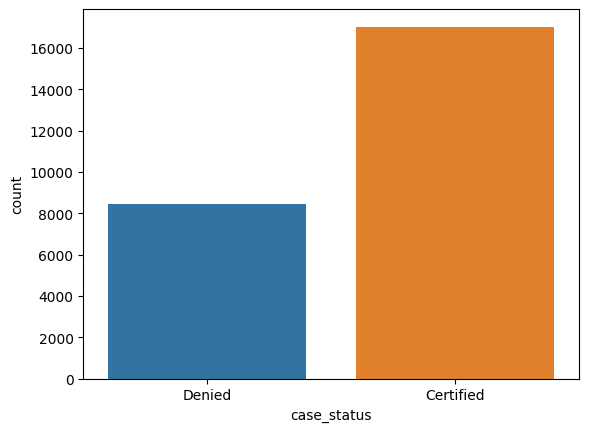

In [171]:
sns.countplot(target,x='case_status')

### Store Data in Parquet Format

In [172]:
features.to_parquet(path="data/features.parquet",index=False)
target.to_parquet(path="data/target.parquet",index=False)

## Time To Live ( Difference in time of feature and target)

In [315]:
timestamps_ttl = pd.date_range(end = pd.Timestamp.now(),
                           periods = len(df),freq = 'D').to_frame(name = 'event_timestamp', index = False)
timestamps_ttl.head()

,event_timestamp
0,1953-02-19 16:02:49.893268
1,1953-02-20 16:02:49.893268
2,1953-02-21 16:02:49.893268
3,1953-02-22 16:02:49.893268
4,1953-02-23 16:02:49.893268


In [319]:
timestamps_ttl - timestamps

,event_timestamp
0,0 days 00:16:44.585201
1,0 days 00:16:44.585201
2,0 days 00:16:44.585201
3,0 days 00:16:44.585201
4,0 days 00:16:44.585201
...,...
25475,0 days 00:16:44.585201
25476,0 days 00:16:44.585201
25477,0 days 00:16:44.585201
25478,0 days 00:16:44.585201


In [321]:
features = pd.concat(objs = [case_id, timestamps, features], axis = 1)
target = pd.concat(objs = [case_id, timestamps_ttl, target], axis =1)

In [322]:
features.head()

,case_id,event_timestamp,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,unit_of_wage_Hour,unit_of_wage_Month,...,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,has_job_experience,requires_job_training,full_time_position,education_of_employee,no_of_employees,company_age,prevailing_wage
0,EZYV01,1953-02-19 15:46:05.308067,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.517300,-0.943712,-1.398537
1,EZYV02,1953-02-20 15:46:05.308067,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,3.0,0.030912,-0.454005,0.169835
2,EZYV03,1953-02-21 15:46:05.308067,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.885076,-1.069026,0.919079
3,EZYV04,1953-02-22 15:46:05.308067,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.343550,1.625983,0.169994
4,EZYV05,1953-02-23 15:46:05.308067,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,3.0,-0.432287,-0.724210,1.428604


In [323]:
target.head()

,case_id,event_timestamp,case_status
0,EZYV01,1953-02-19 16:02:49.893268,Denied
1,EZYV02,1953-02-20 16:02:49.893268,Certified
2,EZYV03,1953-02-21 16:02:49.893268,Denied
3,EZYV04,1953-02-22 16:02:49.893268,Denied
4,EZYV05,1953-02-23 16:02:49.893268,Certified


In [227]:
features.to_parquet(path="data/features_exp.parquet",index=False)
target.to_parquet(path="data/target_exp.parquet",index=False)

## TTL ( Difference in time of feature and target + added some rows with different time)

In [345]:
data_point = features.iloc[-4]
data_point

case_id                                            EZYV25480
event_timestamp                   2022-11-23 15:46:05.308067
continent_Africa                                         0.0
continent_Asia                                           1.0
continent_Europe                                         0.0
continent_North America                                  0.0
continent_Oceania                                        0.0
continent_South America                                  0.0
unit_of_wage_Hour                                        0.0
unit_of_wage_Month                                       0.0
unit_of_wage_Week                                        0.0
unit_of_wage_Year                                        1.0
region_of_employment_Island                              0.0
region_of_employment_Midwest                             1.0
region_of_employment_Northeast                           0.0
region_of_employment_South                               0.0
region_of_employment_Wes

In [346]:
new_data = data_point.copy()

In [347]:
new_data[1] = data_point[1]  + pd.Timedelta(5,unit="min")
new_data[2] = data_point[2]  + 100

In [348]:
new_data

case_id                                            EZYV25480
event_timestamp                   2022-11-23 15:51:05.308067
continent_Africa                                       100.0
continent_Asia                                           1.0
continent_Europe                                         0.0
continent_North America                                  0.0
continent_Oceania                                        0.0
continent_South America                                  0.0
unit_of_wage_Hour                                        0.0
unit_of_wage_Month                                       0.0
unit_of_wage_Week                                        0.0
unit_of_wage_Year                                        1.0
region_of_employment_Island                              0.0
region_of_employment_Midwest                             1.0
region_of_employment_Northeast                           0.0
region_of_employment_South                               0.0
region_of_employment_Wes

In [349]:
pd.DataFrame(new_data).T

,case_id,event_timestamp,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,unit_of_wage_Hour,unit_of_wage_Month,...,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,has_job_experience,requires_job_training,full_time_position,education_of_employee,no_of_employees,company_age,prevailing_wage
25479,EZYV25480,2022-11-23 15:51:05.308067,100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.218742,1.012247,-0.067763


In [350]:
features = pd.concat([features,pd.DataFrame(new_data).T],axis=0).reset_index().drop("index",axis=1)

In [351]:
features

,case_id,event_timestamp,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,unit_of_wage_Hour,unit_of_wage_Month,...,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West,has_job_experience,requires_job_training,full_time_position,education_of_employee,no_of_employees,company_age,prevailing_wage
0,EZYV01,1953-02-19 15:46:05.308067,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.5173,-0.943712,-1.398537
1,EZYV02,1953-02-20 15:46:05.308067,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,3.0,0.030912,-0.454005,0.169835
2,EZYV03,1953-02-21 15:46:05.308067,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2.885076,-1.069026,0.919079
3,EZYV04,1953-02-22 15:46:05.308067,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,-1.34355,1.625983,0.169994
4,EZYV05,1953-02-23 15:46:05.308067,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,3.0,-0.432287,-0.72421,1.428604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25479,EZYV25480,2022-11-23 15:46:05.308067,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.218742,1.012247,-0.067763
25480,EZYV25480,2022-11-23 15:26:05.308067,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.218742,1.012247,-0.067763
25481,EZYV25480,2022-11-23 16:06:05.308067,51.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.218742,1.012247,-0.067763
25482,EZYV25480,2022-11-23 16:06:05.308067,100.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.218742,1.012247,-0.067763


## Add new Target

In [353]:
target

,case_id,event_timestamp,case_status
0,EZYV01,1953-02-19 16:02:49.893268,Denied
1,EZYV02,1953-02-20 16:02:49.893268,Certified
2,EZYV03,1953-02-21 16:02:49.893268,Denied
3,EZYV04,1953-02-22 16:02:49.893268,Denied
4,EZYV05,1953-02-23 16:02:49.893268,Certified
...,...,...,...
25475,EZYV25476,2022-11-19 16:02:49.893268,Certified
25476,EZYV25477,2022-11-20 16:02:49.893268,Certified
25477,EZYV25478,2022-11-21 16:02:49.893268,Certified
25478,EZYV25479,2022-11-22 16:02:49.893268,Certified


In [354]:
data_point = target.iloc[-1]
new_data = data_point.copy()
data_point

case_id                             EZYV25480
event_timestamp    2022-11-23 16:02:49.893268
case_status                         Certified
Name: 25479, dtype: object

In [355]:
new_data[1] = data_point[1]  - pd.Timedelta(5,unit="min")

In [356]:
new_data

case_id                             EZYV25480
event_timestamp    2022-11-23 15:57:49.893268
case_status                         Certified
Name: 25479, dtype: object

In [357]:
target = pd.concat([target,pd.DataFrame(new_data).T],axis=0).reset_index().drop("index",axis=1)

In [358]:
target

,case_id,event_timestamp,case_status
0,EZYV01,1953-02-19 16:02:49.893268,Denied
1,EZYV02,1953-02-20 16:02:49.893268,Certified
2,EZYV03,1953-02-21 16:02:49.893268,Denied
3,EZYV04,1953-02-22 16:02:49.893268,Denied
4,EZYV05,1953-02-23 16:02:49.893268,Certified
...,...,...,...
25476,EZYV25477,2022-11-20 16:02:49.893268,Certified
25477,EZYV25478,2022-11-21 16:02:49.893268,Certified
25478,EZYV25479,2022-11-22 16:02:49.893268,Certified
25479,EZYV25480,2022-11-23 16:02:49.893268,Certified


In [359]:
features.to_parquet(path="data/features_exp.parquet",index=False)
target.to_parquet(path="data/target_exp.parquet",index=False)

## Conclusion

1. Multiple tables contains different features generated over different times and stored into system in different times.
2. 